In [47]:
import os
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2 as cv

# defined
from utility_function import img_resize, model_namer, model_namer_description, save_ml_model, load_ml_model, load_training_data

In [10]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
# model testing

# filename = '3d_cnn2.h5'
# filename = '3d_cnn3.h5'
# img_resize_factor = 100

# filename = 'cnn3d_100_5_1.75e-14_100_1_relu_50.h5'
# filename = 'cnn3d_100_5_1.75e-14_50_1_relu_50.h5'
# filename = 'cnn3d_1000_5_1.75e-14_40_1_tanh_1.h5'
# filename = 'cnn2d_1000_5_1.75e-14_50_1_relu_100.h5'
# filename = 'cnn2d_1000_5_1.75e-14_100_1_tanhmax_100.h5'
# filename = 'cnn3d_2000_5_1.75e-14_50_1_relu-dense_1.pkl'
# filename = 'cnn2d_1000_5_1.75e-14_50_255_max_100.pkl'
# filename = 'cnn2d_1000_5_1.75e-14_50_255_max_100.pkl'
# filename = 'cnn2d_v1_1000_5_1.75e-14_50_max-based_100.pkl'
# filename = 'cnn2d_v2_1000_5_1.75e-14_50_shrinkX_100.pkl'
# filename = 'cnn3d_v1_1000_5_1.75e-14_50_shrinkX-tanh_10.pkl' # do not predict anything
# filename = 'cnn2d_v3_1000_5_1.75e-14_50_stack-2d_10.pkl' # do not predict anything
# filename = 'cnn2d_v3_1000_5_1.75e-14_50_no-pooling_100.pkl' # do not predict anything
# filename = 'cnn2d_v4_1000_5_1.75e-14_50_pooling_100.pkl'
# filename = 'cnn3d_v2_1000_5_1.75e-14_50_pooling_100.pkl'
# filename = 'cnn3d_v3_1000_5_1.75e-14_50_2-3dconv_100.pkl' # do not predict anything
# filename = 'cnn3d_v3_1000_5_1.75e-14_50_pooling-lr_100.pkl'

filename = 'cnn3d_v3_2000_5_1.75e-14_50_kt-all_100.pkl'
info = model_namer_description(filename)
model = load_ml_model(filename)
model.summary()

Model description:
 
                - Dimension: 3
 
                - Version: v3

                - Number of samples: 2000

                - FMC subsampling frequency: 5

                - FMC scaler: 1.75e-14

                - Img resize factor: 50

                - Remark: kt-all

                - Epochs: 100

    
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 892, 14, 14, 5)    185       
                                                                 
 dropout (Dropout)           (None, 892, 14, 14, 5)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 446, 7, 7, 5)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 109270)            0   

In [13]:
x_dimension = int(info['Dimension'])
img_resize_factor = int(info['img_resize'])
epochs = int(info['epochs'])
shrinkx = False

X, y = load_training_data(num_sample=3500, 
                          x_dimension=x_dimension, 
                          img_resize_factor=img_resize_factor,
                          shrinkx = shrinkx)

The shape of X is (3500, 895, 16, 16, 1)
The shape of y is (3500, 7200)


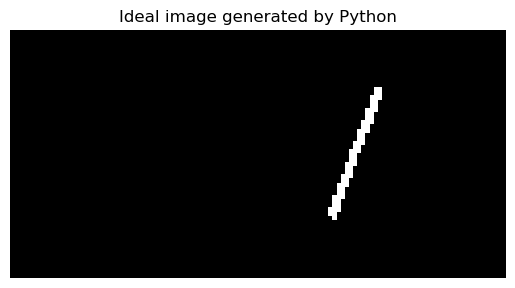

1/1 [==============================] - 0s 50ms/step


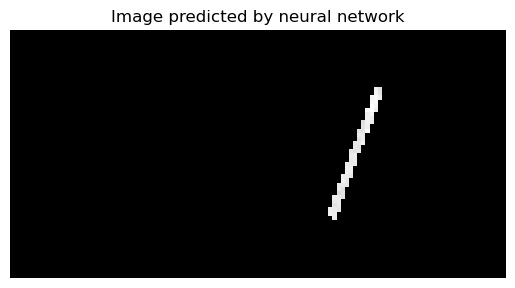

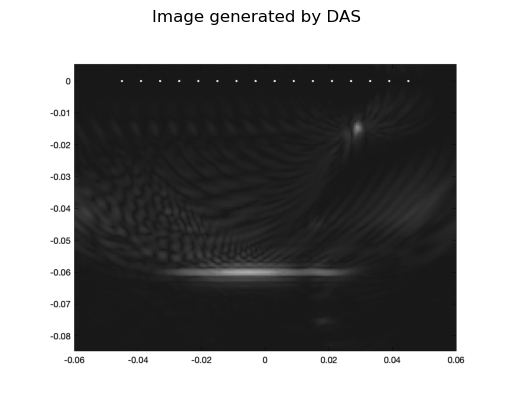

In [31]:
# 1078 # 1073 # 1070

# 2600 # 2700 
num_test = 2500
threshold = -0.1 
stack = False

true_img = y[num_test].reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
fig, ax = plt.subplots()
ax.imshow(true_img, cmap ='gray')
plt.title('Ideal image generated by Python')
plt.axis('off')
plt.show()

if shrinkx == True:
    xshape = 865
else:
    xshape = 895

if x_dimension == 3:
    ypred = model.predict(X[num_test].reshape(-1, xshape, 16, 16, 1))
elif x_dimension == 2:
    if stack == True:
        ypred = model.predict(X[num_test].reshape(-1, xshape, 16, 16))
    else:
        ypred = model.predict(X[num_test].reshape(-1, xshape, 16*16, 1))
    
ypred[ypred <= threshold] = 0
ypred[ypred > threshold] = np.abs(ypred[ypred > threshold])*255
img = ypred.reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
fig, ax = plt.subplots()
ax.imshow(img, cmap ='gray')
plt.title('Image predicted by neural network')
plt.axis('off')
plt.show()

dirName_das_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_FMC"
# Read image in greyscale 
image_das_fmc = cv.imread(f'{dirName_das_fmc}/Figure_{num_test+1}_fmc.png',cv.IMREAD_GRAYSCALE)  # convert to array

plt.imshow(image_das_fmc, cmap='gray')
plt.title('Image generated by DAS')
plt.axis('off')
plt.show()

## Keras Tuner Result Summary

In [57]:

def read_keras_tuner_log(filename):

    with open(f'Keras_tuner_log/{filename}.txt') as f:
        contents = f.read().splitlines()

    info = contents[:9]
    print(info)
    result = contents[9:]

    rank = 0
    model_compile = []
    for i in range(len(result)):
        if result[i] == 'Trial summary':
            rank += 1
            pass
        elif result[i] == 'Hyperparameters:':
            model = {}
            model['Rank'] = rank
        else:
            key, value = result[i].split(': ')
            if key == 'Score':
                model['Val_loss'] = value
                model_compile.append(model)
            else:
                model[key] = value
            

    df = pd.DataFrame.from_dict(model_compile).set_index('Rank')
    df = df.drop(['tuner/epochs','tuner/initial_epoch','tuner/bracket','tuner/round','tuner/trial_id'], axis = 1)
    
    return df

read_keras_tuner_log('o7122780')
read_keras_tuner_log('o7121864')

['Message 1:', 'Num GPUs Available:  0', '______', 'The shape of X is (2000, 895, 16, 16, 1)', 'The shape of y is (2000, 7200)', 'Results summary', 'Results in fyp_model_search/3dcnn_1conv_all_gpu_2', 'Showing 10 best trials', '<keras_tuner.engine.objective.Objective object at 0x15016416a2b0>']
['Message 1:', 'Num GPUs Available:  0', '______', 'The shape of X is (2000, 895, 16, 16, 1)', 'The shape of y is (2000, 7200)', 'Results summary', 'Results in fyp_model_search/3dcnn_1conv_all_gpu', 'Showing 10 best trials', '<keras_tuner.engine.objective.Objective object at 0x145c21f8a2b0>']


,layers,filters_0,kernels_0,activation_,dropout,pooling_0,dense_units_,dropout2,lr,filters_1,kernels_1,pooling_1,Val_loss
Rank,,,,,,,,,,,,,
1,1,5,4,tanh,True,max,1000,True,0.0001735701471314462,2,5,avg,0.020990939810872078
2,1,12,5,relu,True,avg,1500,True,0.0001217170995230137,3,5,max,0.021442623808979988
3,1,5,4,tanh,True,max,1000,True,0.0001735701471314462,2,5,avg,0.026099970564246178
4,1,12,5,relu,True,avg,1500,True,0.0001217170995230137,3,5,max,0.028639812022447586
5,1,16,5,tanh,False,avg,2000,True,0.00011159040326724652,15,4,max,0.029070377349853516
6,1,11,5,tanh,False,avg,1000,False,0.00011750076109837058,4,5,avg,0.030609704554080963
7,1,16,5,tanh,False,avg,2000,True,0.00011159040326724652,15,4,max,0.03066534921526909
8,1,11,5,tanh,False,avg,1000,False,0.00011750076109837058,4,5,avg,0.03070610947906971
9,1,12,5,relu,True,avg,1500,True,0.0001217170995230137,3,5,max,0.030805451795458794
